# Regressor
1. load datasets
1. sample from datasets
1. construct features
1. construct labels (load from logs)

In [2]:
# load datasets:
import importlib
import random
import argparse
import configparser
import numpy as np
import networkx as nx
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim


from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math


from dataset_utils import node_feature_utils
from dataset_utils.node_feature_utils import *
import my_utils as utils
import sys,os
sys.path.append(os.getcwd())


importlib.reload(utils)

# save datasets
import pickle as pk

def save_datasets(datasets, file_name):
    with open(file_name, 'wb') as f:
        pk.dump(datasets, f)

def load_datasets(file_name):
    with open(file_name, 'rb') as f:
        datasets = pk.load(f)
    return datasets

Using backend: pytorch


# Load regressor datasets

In [5]:
"""
- small: MUTAG, NCI1, DD, CIFAR10, MNIST, imdb_b, ogbg-molhiv, ogbg-molbace, ogbg-moltox21
- middle: ogbg-ppa, (ogbg-molpcba, ogbg-code2, to be done)
10-fold: MUTAG, NCI1, DD, CIFAR10, MNIST, imdb_b, SynCC
one split: ogbg-molhiv, ogbg-molbace, ogbg-moltox21, ogbg-ppa

use 10-fold to trian, use one split to test

"""
"""
Medium	ogbg-molpcba	>=1.2.2	437,929	26.0	28.1	128	Scaffold	Binary classification	AP
Medium	ogbg-ppa	>=1.1.1	158,100	243.4	2,266.1	1	Species	Multi-class classification	Accuracy
Medium	ogbg-code2
"""

# small scale: < 10k
train_datasets_names = ['mutag', 'nci1', 'dd', 'imdb_b', 'imdb_m', 'mnist', 'cifar10']
test_datasets_names = ['ogbg_molhiv', 'ogbg_moltox21', 'ogbg_molbace']

train_datasets = []
for k in train_datasets_names:
    train_datasets.append((load_datasets(f'{k}_datasets.pkl'), k))

test_datasets = []
    
for k in test_datasets_names:
    test_datasets.append((load_datasets(f'{k}_datasets.pkl'),k))
    
# SynCC
syn_cc_datasets = load_datasets('syn_datasets.pkl')

In [7]:
print(len(syn_cc_datasets))
print(len(train_datasets))
print(len(test_datasets))
print('train:')
a = [print(len(d[0])) for d in train_datasets]
print('test:')
a = [print(len(d[0])) for d in test_datasets]
# extend each dataset:

90
7
3
train:
10
10
10
10
10
1
1
test:
3
1
10


In [ ]:
# combine all datasets:
    # F1: avgD:
    # F2: avgCC:
    # F3: avgD/N:
    # F4: node num N:
    # F5: labels
    # calculate each dimension of labels:
    # F6: cycles:
real_datasets = []

train_datasets_pairs, test_datasets_pairs = [],[]

# for i, d in enumerate(syn_cc_datasets):
#     if int(i//10) == 1 or int(i//10) == 8:
#         train_datasets_paris.append(((d[0], d[1]), f'syn_cc:{str(round((((int(i/10)+1))/10.0), 1))}_{(i%10+1)}'))
    
# for i, d in enumerate(syn_cc_datasets):
#     all_datasets_paris.append((d, f'syn_cc:{str(round((((int(i/10)+1))/10.0), 1))}_{(i%10+1)}'))

for k, d in enumerate(train_datasets):
    train_datasets_pairs.extend([(fold, f'small_:{train_datasets_names[k]}_{i}') for i, fold in enumerate(d)])

for k, d in enumerate(test_datasets):
    test_datasets_pairs.extend([(fold, f'middle:{test_datasets_names[k]}_{i}') for i, fold in enumerate(d)])

train_name_id_dict = {i:d[1] for i, d in enumerate(train_datasets_pairs)}
test_name_id_dict = {i:d[1] for i, d in enumerate(test_datasets_pairs)}

def belong_to_which_datasets(idx, name_id_dict):
    return name_id_dict[idx]

print(len(train_name_id_dict), len(test_name_id_dict))

new_train_datasets = [d[0] for d in train_datasets_pairs]
new_test_datasets = [d[0] for d in test_datasets_pairs]

In [6]:
# combine all datasets:

# small scale: < 10k
all_datasets = []

for d in train_datasets+test_datasets:
    all_datasets.extend([fold for fold in d])

print(len(all_datasets))
# only select 20 and 80 of syn_cc_datasets
# all_datasets.extend([d for i, d in enumerate(syn_cc_datasets) if int(i//10) == 1])
# all_datasets.extend([d for i, d in enumerate(syn_cc_datasets) if int(i//10) == 8])

print(len(all_datasets))

66
66


In [ ]:

belong_to_which_datasets(18, train_name_id_dict)

# for (d, name) in all_datasets_paris:
#     print(np.isnan(d[0]).any(),np.isnan(d[1]).any(), name)

# construct regressor

In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt


import numpy as np
from sklearn.preprocessing import StandardScaler

def plot_bars(preds, Y, show_data, regressor_name):
    # es = []
    # for i in range(data_block.shape[0]):
    #     d= data_block[i]
    #     es.append((get_E(d[1, 0], d[3, 0], d[0, 0], d[4, 0]), show_data[i]))

    sorted_indices = np.argsort(Y)
    predictions_sorted = preds[sorted_indices]
    ground_truth_sorted = Y[sorted_indices]

    bar_width = 0.3
    bar_positions = np.arange(len(show_data)) * 1.5
    x_label_positions = bar_positions + bar_width / 2

    fig, ax = plt.subplots(figsize=(len(show_data)/3, 3), dpi=300)
    print(bar_positions.shape)
    print(predictions_sorted.shape)
    
    ax.bar(bar_positions.squeeze(), predictions_sorted.squeeze(), width=bar_width, color='blue', hatch='/', label='Predictions')
    ax.bar(bar_positions + bar_width, ground_truth_sorted, width=bar_width, color='orange', hatch='-', label='Ground Truth')
    ax.set_xticks(x_label_positions)
    ax.set_xticklabels(show_data, rotation=45, ha='right')
    ax.set_ylabel('Effectiveness', fontsize=16)
    ax.set_xlabel('Dataset ID', fontsize=16)
    ax.set_axisbelow(True)
    ax.grid(linestyle='dashed',zorder=0)
    ax.legend( fontsize=16, title_fontsize=16)
    ax.set_title(f'Predictions by {regressor_name}', fontsize=16)
    
    plt.show()
    
    
def mean_norm(x):
    scaler = StandardScaler()
    return scaler.fit_transform(x), scaler


class CustomDataset(Dataset):
    def __init__(self, data):
        self.X = torch.tensor([t[0] for t in data], dtype=torch.float32)
        self.Y = torch.tensor([t[1] for t in data], dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


np.random.seed(42)

def generate_data(num_samples):
    features = np.random.rand(num_samples, 26)
    labels = np.random.rand(num_samples, 1)
    return [(features[i], labels[i]) for i in range(num_samples)]

class MLPRegressor(nn.Module):
    def __init__(self, input_dim=26):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            # nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

    
def evaluate(loader, model, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    preds = []
    Y = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)
            preds.append(outputs.cpu().numpy())
            Y.append(labels.cpu().numpy())
            
    
    preds = np.concatenate(preds, axis=0)
    Y = np.concatenate(Y, axis=0).ravel()
    
    mae = mean_absolute_error(Y, preds)
    mse = mean_squared_error(Y, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(Y, preds)
    
    results = (mae, mse, rmse, r2)
    return mse, results, preds, Y

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mlp_regressor(input_dim, train_loader, val_loader, test_loader, scaler_x, scaler_y, show_data=None):

    model = MLPRegressor(input_dim).to(device)
    criterion = nn.MSELoss()
    # criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 500
    train_losses, val_losses = [], []
    min_val_loss = float("inf") # initialize with a large value

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(-1, 1))
            loss.backward()
            optimizer.step()

        train_loss, _, _, _ = evaluate(train_loader, model, criterion, device)
        val_loss, _,_,_ = evaluate(val_loader, model, criterion, device)
        
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), "best_mlp_regressor_model.pth")

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


    model.load_state_dict(torch.load("best_mlp_regressor_model.pth"))
    test_loss, test_results, test_preds, test_Y = evaluate(test_loader, model, criterion, device)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f'MLPs: {round(test_results[0], 2)} & {round(test_results[1], 2)} & {round(test_results[2], 2)} & {round(test_results[3], 2)}')

    plot_bars(scaler_y.inverse_transform(test_preds), scaler_y.inverse_transform(test_Y), show_data,  "MLP Regressor")

    # Plot train and validation loss curves
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Train and Validation Loss Curves")
    plt.show()


In [8]:

X = np.array([t[0] for t in all_datasets])
Y = np.array([t[1] for t in all_datasets])

normalized_x, scaler_x = mean_norm(X)
normalized_y, scaler_y = mean_norm(Y.reshape(-1, 1))

print(normalized_x.shape, normalized_y.shape)

print(len(normalized_x))
normed_combined_data = [(normalized_x[i], normalized_y[i]) for i in range(normalized_x.shape[0])]

dataset = CustomDataset(normed_combined_data)

train_size = int(0.6 * len(dataset))
val_size = int(0.0 * len(dataset))

test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# dataset_ids = [belong_to_which_datasets(i) for i in test_data.indices]
# print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))
# print(len(dataset_ids))

(66, 26) (66, 1)
66


# use 10-fold to predict one fold:

In [ ]:

# X_train = np.array([t[0] for t in new_train_datasets])
# Y_train = np.array([t[1] for t in new_train_datasets])

# X_test = np.array([t[0] for t in new_test_datasets])
# Y_test = np.array([t[1] for t in new_test_datasets])

# normalized_x_train, scaler_x_train = mean_norm(X_train)
# normalized_y_train, scaler_y_train = mean_norm(Y_train.reshape(-1, 1))

# normalized_x_test = scaler_x_train.transform(X_test)


# # print(normalized_x.shape, normalized_y.shape)

# # print(len(normalized_x))

# normed_combined_data_train = [(normalized_x_train[i], normalized_y_train[i]) for i in range(normalized_x_train.shape[0])]
# # normed_combined_data_train = [(normalized_x_train[i], Y_train[i]) for i in range(normalized_x_train.shape[0])]
# dataset = CustomDataset(normed_combined_data_train)

# train_size = int(0.7 * len(dataset))
# val_size = len(dataset) - train_size

# train_data, val_data = random_split(dataset, [train_size, val_size])

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# normed_combined_data_test = [(normalized_x_test[i], Y_test[i]) for i in range(normalized_x_test.shape[0])]
# dataset_test = CustomDataset(normed_combined_data_test)
# test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

# dataset_ids = [belong_to_which_datasets(i, test_name_id_dict) for i in range(len(dataset_test))]
# print(len(dataset_ids))

# print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))
# # dataset_ids = []

In [ ]:
# 10-fold to predict one-fold dataset:
mlp_regressor(26, train_loader, val_loader, test_loader, scaler_x_train, scaler_y_train, show_data=dataset_ids)

In [32]:
# all_datasets mixed:
mlp_regressor(26, train_loader, val_loader, test_loader, scaler_x, scaler_y, show_data=[i for i in range(len(test_data))])

ValueError: need at least one array to concatenate

In [9]:
def train_regressor(loader, regressor):
    X = []
    Y = []
    
    for inputs, labels in loader:
        X.extend(inputs.cpu().numpy())
        Y.extend(labels.cpu().numpy())

    X = np.array(X)
    Y = np.array(Y).ravel()

    regressor.fit(X, Y)
    

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math


def regressor_evaluate(loader, regressor):
    X = []
    Y = []

    for inputs, labels in loader:
        X.extend(inputs.cpu().numpy())
        Y.extend(labels.cpu().numpy())

    X = np.array(X)
    Y = np.array(Y).ravel()

    preds = regressor.predict(X)
    mae = mean_absolute_error(Y, preds)
    mse = mean_squared_error(Y, preds)
    rmse = math.sqrt(mse)
    r2 = r2_score(Y, preds)
    
    results = (mae, mse, rmse, r2)
    return mse, results, preds, Y


# baseline regressors:
- random forest

(27,)
(27,)


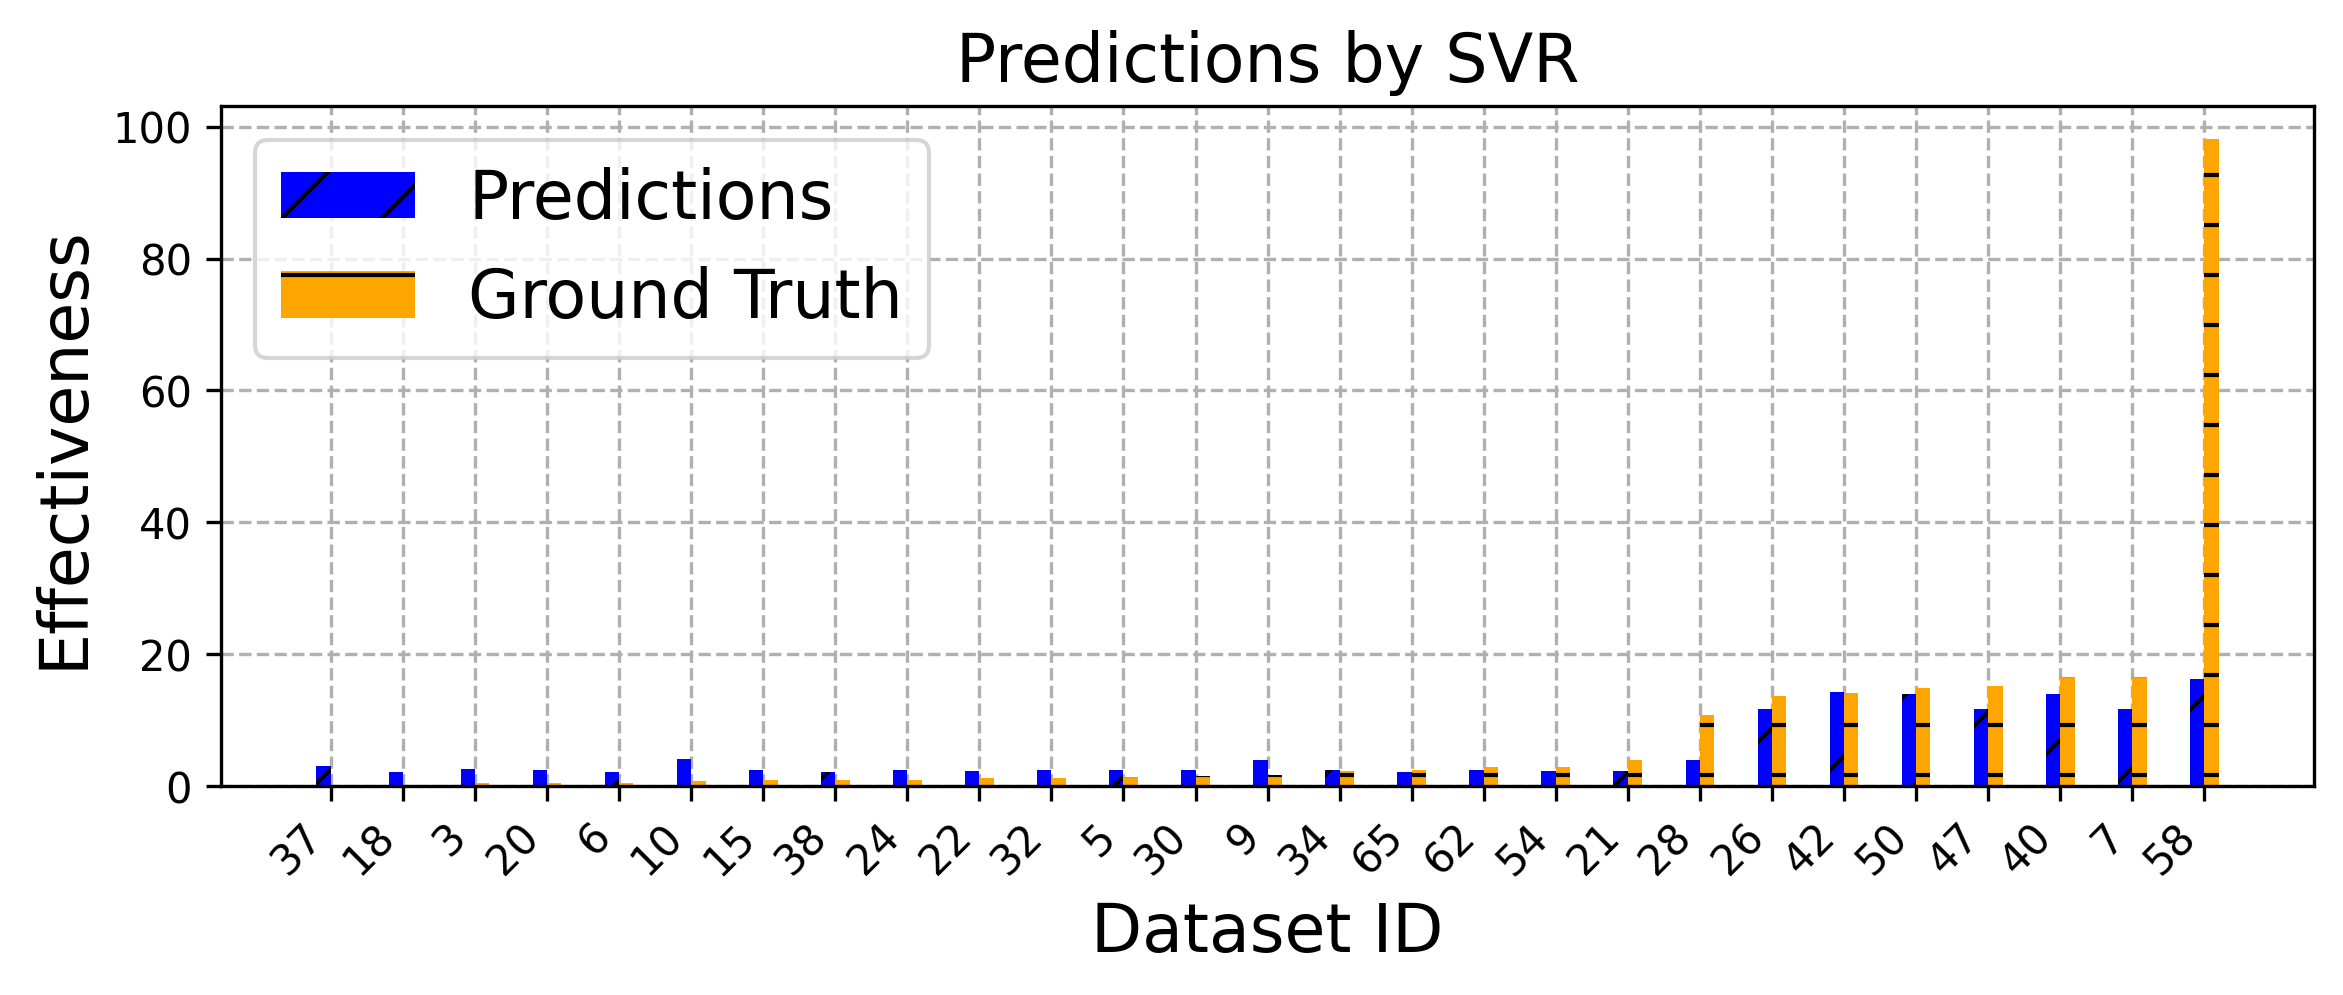

SVR: 0.36 & 1.4 & 1.18 & 0.26
(27,)
(27,)


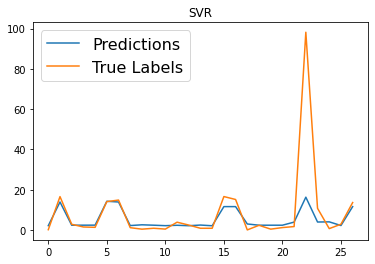

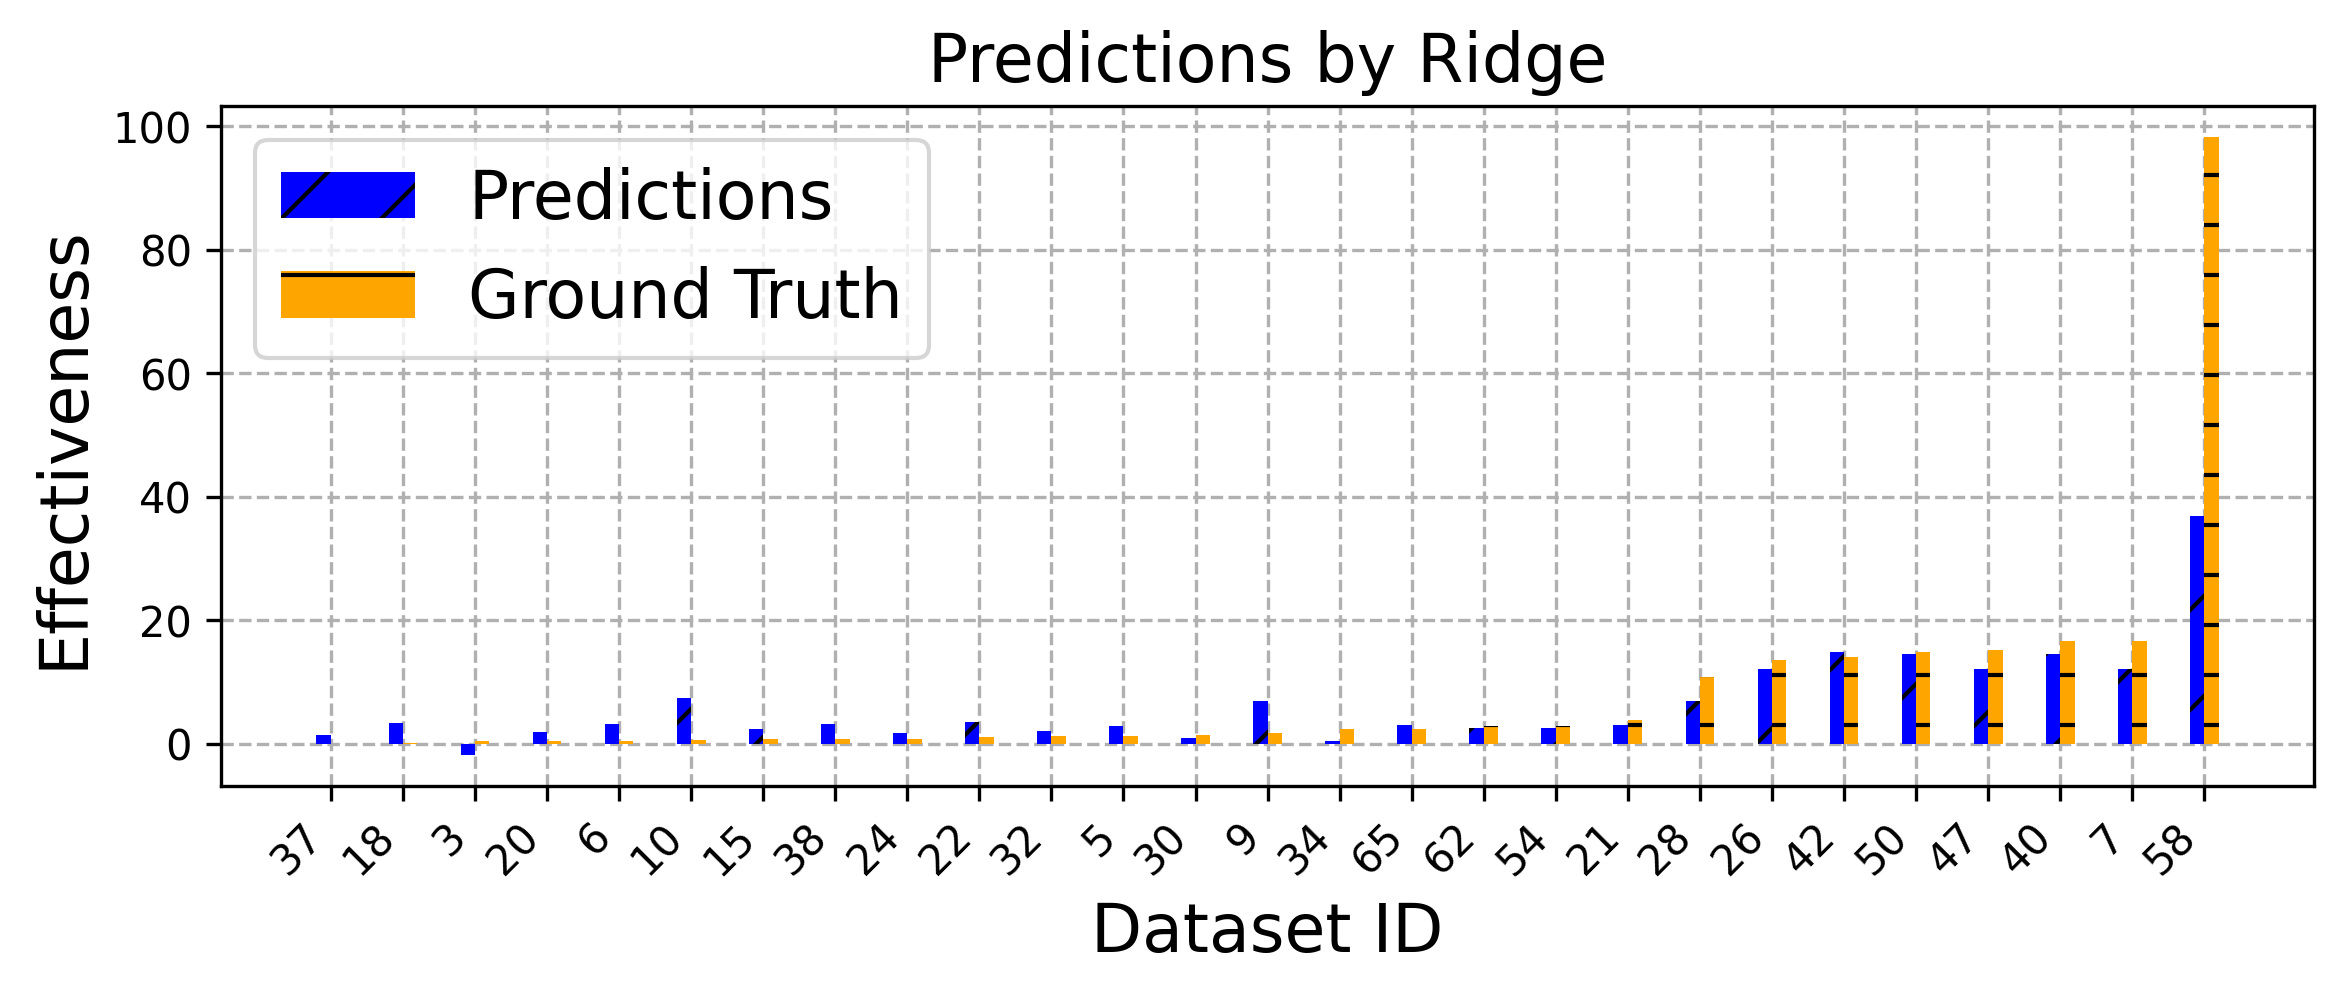

Ridge: 0.3100000023841858 & 0.800000011920929 & 0.9 & 0.58
(27,)
(27,)


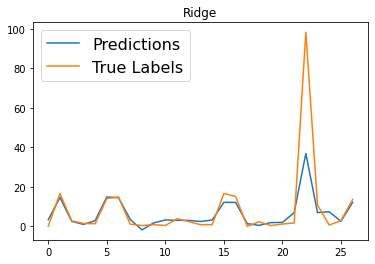

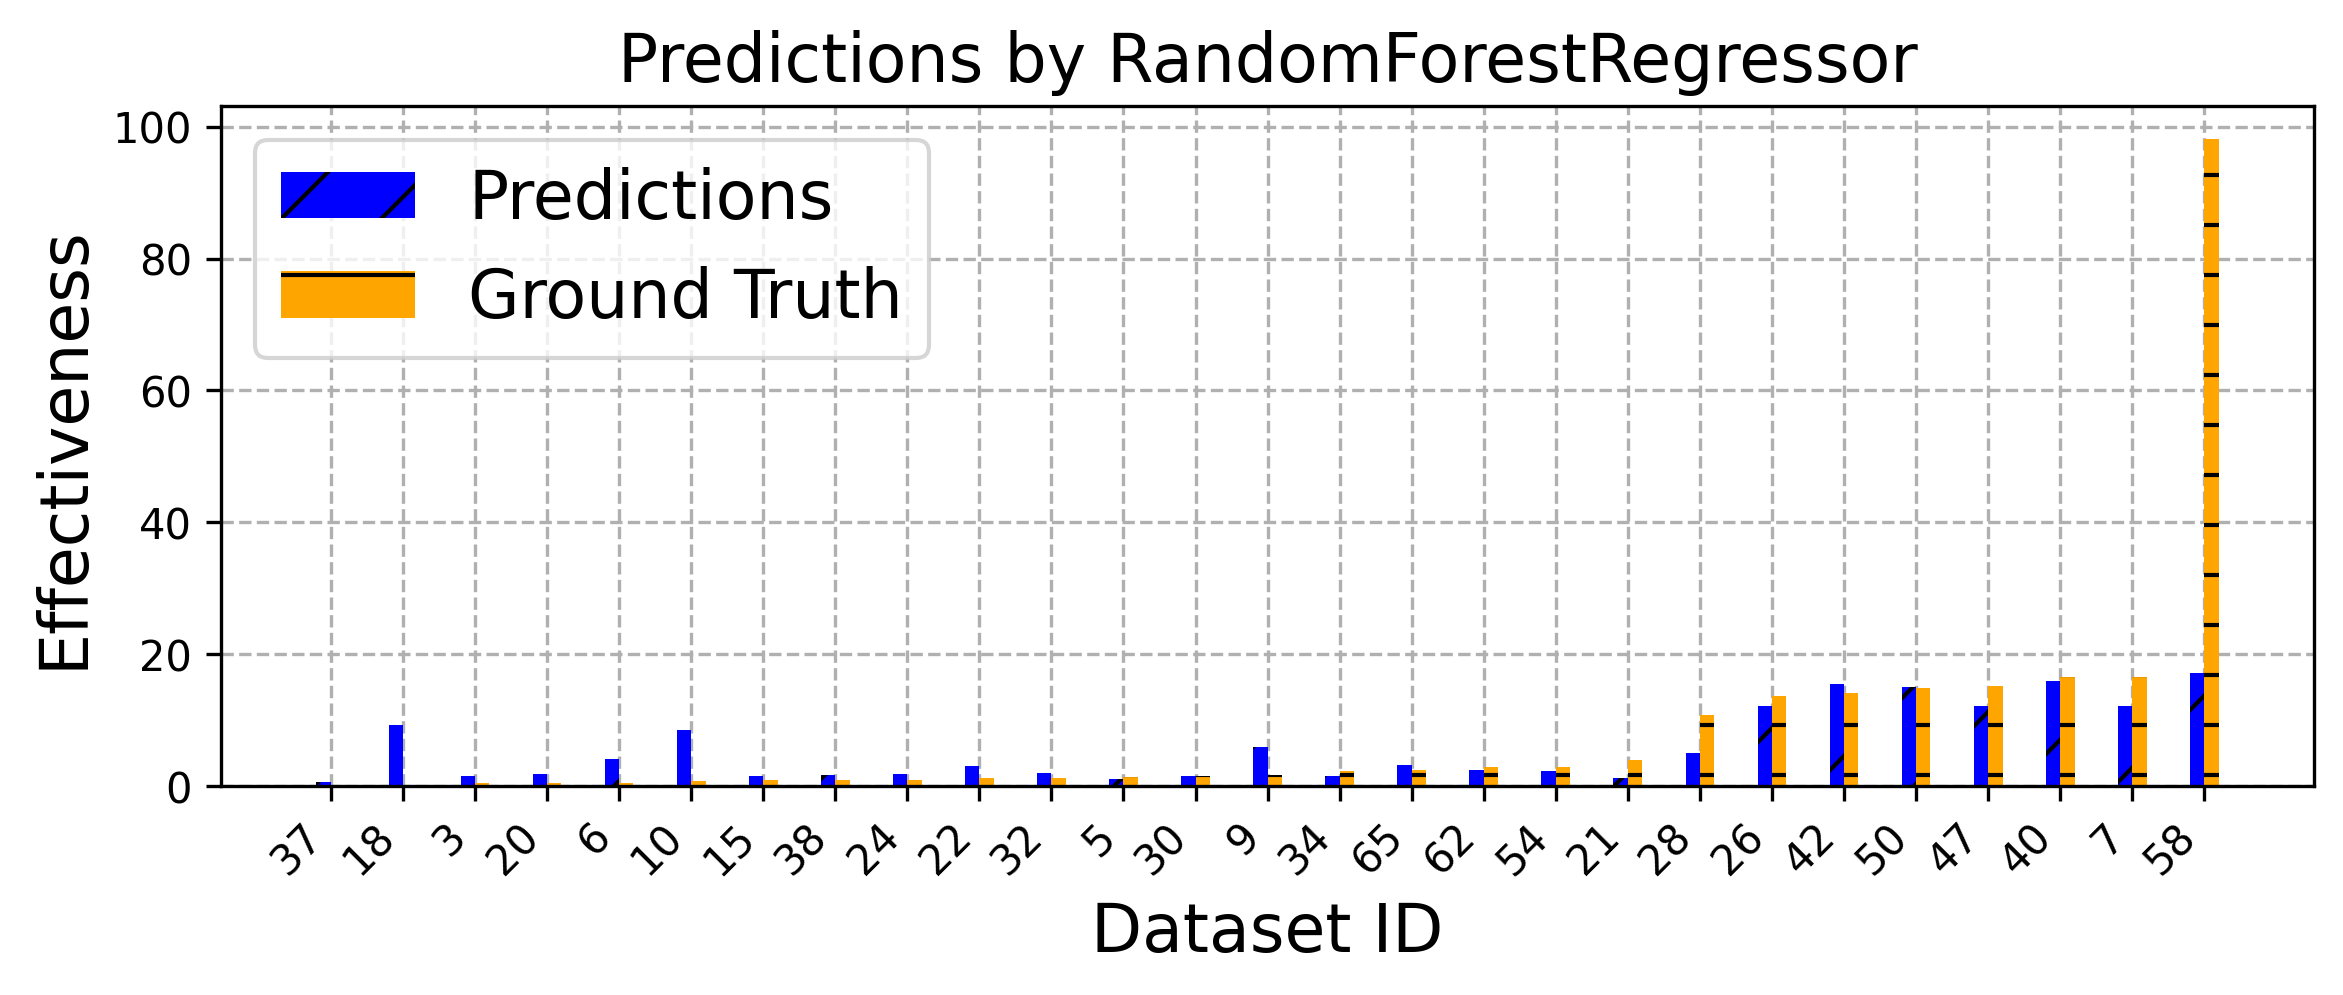

RandomForestRegressor: 0.38 & 1.39 & 1.18 & 0.27
(27,)
(27,)


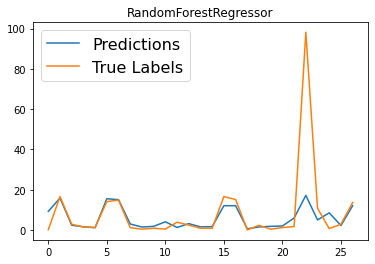

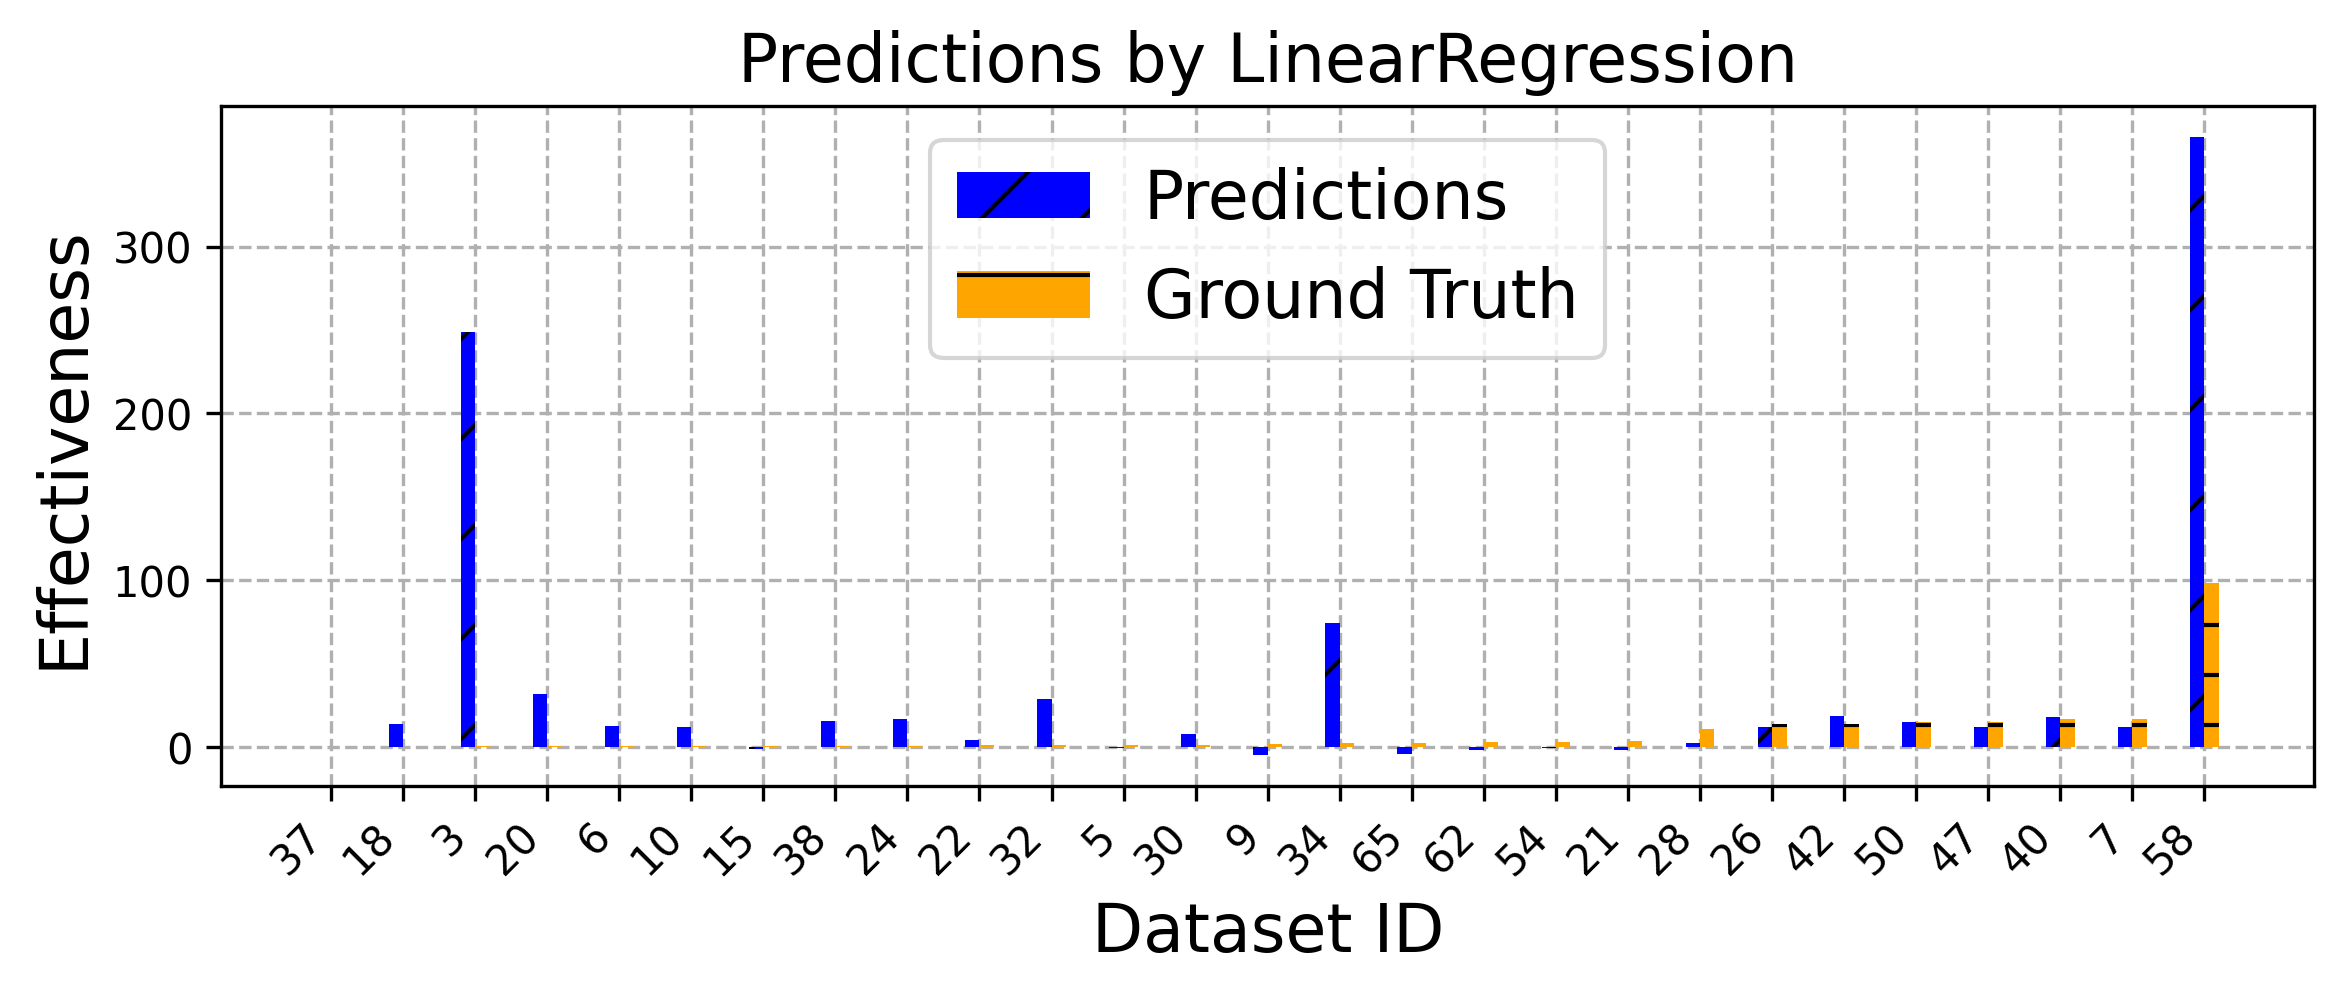

LinearRegression: 2.140000104904175 & 28.850000381469727 & 5.37 & -14.19


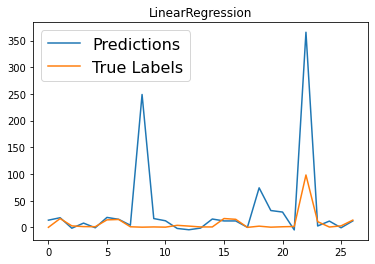

In [10]:
# ax.legend()
def run_regressor(regressor, regressor_name):
        
    # Choose a regressor
    # regressor = GradientBoostingRegressor(random_state=42)

    train_regressor(train_loader, regressor)

    # train_loss, train_results, train_preds, train_Y = regressor_evaluate(train_loader, regressor)
    # val_loss, val_results, val_preds, val_Y = regressor_evaluate(val_loader, regressor)
    test_loss, test_reuslts, test_preds, test_Y = regressor_evaluate(test_loader, regressor)

    # decide which test dataset belong to:
    
    # dataset_ids = [belong_to_which_datasets(i) for i in test_data.indices]
    dataset_ids = [i for i in test_data.indices]
    
    plot_bars(scaler_y.inverse_transform(test_preds), scaler_y.inverse_transform(test_Y), dataset_ids, regressor_name)
    
    # print(f"regressor_name: {regressor_name}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f} \
    #       (mse, rmse, r^2): {test_reuslts}")
    
    print(f'{regressor_name}: {round(test_reuslts[0], 2)} & {round(test_reuslts[1], 2)} & {round(test_reuslts[2], 2)} & {round(test_reuslts[3], 2)}')
    plt.figure()
    plt.plot(scaler_y.inverse_transform(test_preds), label="Predictions")
    plt.plot(scaler_y.inverse_transform(test_Y), label="True Labels")
    plt.title(regressor_name)
    plt.legend(fontsize=16)
    
    return test_preds, test_Y

from sklearn.svm import SVR
from sklearn.linear_model import Ridge

# Choose a regressor
regressors = {'SVR': SVR(),'Ridge': Ridge(), "RandomForestRegressor": RandomForestRegressor(),  
              "LinearRegression": LinearRegression()}

# regressors = {"RandomForestRegressor": RandomForestRegressor()}

results = []
for k, regressor in regressors.items():
    results.append(run_regressor(regressor, k))

# check correlation of preds and GT

In [1]:
print(len(results))
from scipy import stats
from minepy import pstats, cstats

# Assuming you have your linear regression model's predictions (y_pred) and ground truth Y (y_true)
# Calculate Spearman correlation coefficient and p-value

for pred_s, y_s in results:
    # spearman correlation of pred and y:
    
    spearman_corr, p_value = stats.spearmanr(pred_s, y_s)
    print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    # # add pearson correlation of pred and y:
    # pearson_corr, p_value = stats.pearsonr(pred_s, y_s)
    # print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
    # print(f"P-value: {p_value:.6f}")
    
    

NameError: name 'results' is not defined

In [ ]:
import xgboost as xgb
import lightgbm as lgb


regressors = {'XG boost': xgb.XGBRegressor(objective ='reg:squarederror'),
              'LGBMRegressor': lgb.LGBMRegressor()}

for k, regressor in regressors.items():
    run_regressor(regressor, k)

In [ ]:
# use test dataset to evaluate the model

# average each datasets:

from collections import Counter

test_dataset_idx = [belong_to_which_datasets(i, store_each_len) for i in test_data.indices]
print(Counter(test_dataset_idx))

# Get predictions and true labels from the test dataset
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_labels.extend(labels.squeeze().cpu().numpy())


plt.figure()
plt.plot(scaler_y.inverse_transform(predictions), label="Predictions")
plt.plot(scaler_y.inverse_transform(true_labels), label="True Labels")
plt.legend()


# plot predictions of other real-world datasets

In [ ]:
# CIFAR10 only has on fold
"""
result_GIN_0317_decouple_degree_attr_CIFAR10
result_GIN_0317_mix_degree_attr_CIFAR10
result_GIN_0317_only_attr_CIFAR10
result_GIN_0317_only_degree_CIFAR10
result_GIN_0318_decouple_degree_attr_CIFAR10
result_GIN_0327_finger_mlp_attr_multicrossen_CIFAR10
result_GIN_0401_GIN_degree_CIFAR10
result_GIN_0403_GIN_degree_CIFAR10
"""

MLP_log_path_degree = f'./results/result_GIN_0401_graph_mlp_avgDegree_CIFAR10/MolecularGraphMLP_CIFAR10_assessment/1_NESTED_CV'
GNN_log_path_degree = f'./results/result_GIN_0317_only_degree_CIFAR10/GIN_CIFAR10_assessment/1_NESTED_CV'

MLP_log_path_attr = f'./results/result_GIN_0327_finger_mlp_attr_multicrossen_CIFAR10/MolecularFingerprint_CIFAR10_assessment/10_NESTED_CV'
GNN_log_path_attr = f'./results/result_GIN_0317_only_attr_CIFAR10/GIN_CIFAR10_assessment/1_NESTED_CV'

dataset = datasets_obj['CIFAR10']
cifar10_datasets = E_datasets(dataset, MLP_log_path_degree, GNN_log_path_degree, MLP_log_path_attr, GNN_log_path_attr, fold=1)

